# Apredizagem de Máquina na Detecção de Fraude em Cartões de Crédito

## Instalação de Pacotes
### Importação de Bibliotecas

In [66]:
%%capture

# Leitura, manipulação, e analise exploratoria dos dados
import seaborn as sns
from google.colab import drive
!pip install dataprep
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Limpeza e Pré - Processamento dos dados

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

# Bibliotecas de aprendizagem de máquina (Classificação)

from sklearn.svm import SVC # Suporte Vetor Machine
from sklearn.linear_model import LogisticRegression # Regressão Logística
from sklearn.tree import DecisionTreeClassifier # Árvore de decisão (Decision tree learning)
from sklearn.neighbors import KNeighborsClassifier #KNN - K-ésimo Vizinho mais Próximo (k-nearest neighbors algorithm)
from sklearn.neural_network import MLPClassifier # Rede Neural - Perceptron multicamadas
from sklearn.ensemble import RandomForestClassifier # Floresta aleatória (Random forest)
from sklearn.ensemble import GradientBoostingClassifier # Gradient boosting
from xgboost import XGBClassifier # Xgboost
from lightgbm import LGBMClassifier # Light Gradient Boosting Model (LGBM)
import warnings


from imblearn.over_sampling import RandomOverSampler

warnings.filterwarnings("ignore")


### Conectando ao Google drive (acesso ao banco de dados)

In [67]:
%%capture
drive.mount('/content/drive')

### Leitura do banco de dados

In [68]:
%%capture
atual_dados = pd.read_csv('/content/drive/Shareddrives/Dados/Detecção de Fraudes em Cartão de Crédito/dados_app_T.CSV', sep = ';', encoding = 'latin-1')
atual_dados

## Limpeza / Pré - Processamento dos Dados

O pré-processamento de dados desempenha um papel fundamental na análise de dados e no desenvolvimento de modelos de aprendizado de máquina. É um conjunto de etapas que visa melhorar a qualidade, a integridade e a confiabilidade dos dados, preparando-os para análises subsequentes. Essas etapas incluem desde a limpeza dos dados até a transformação e a redução da dimensionalidade.

In [69]:
%%capture

## Informações das variaveis que vamos trabalhar
# São 122 colunas com as variaveis de cada cliente, sendo que 120 consideramos variáveis explicativas, contendo 307511 linhas com transações
# Obs: Temos variaveis do tipo flutuante, inteira e objeto
atual_dados.info('columns')

In [70]:
%%capture

# Retirada de colunas

atual_dados.drop(["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3", "DIAS_EMPREGADOS", "DIAS_REGISTRO", "DIAS_ID_REGISTRO"], axis=1, inplace= True)
atual_dados.info()


In [71]:
%%capture

# Função que retorna os totais e porcentagens de valores nulos, quantidade de valores unicos, e os tipos das variaveis: ###

def meta_data(atual_dados):
    total = atual_dados.isnull().sum()
    percent = (atual_dados.isnull().sum()/atual_dados.isnull().count()*100)
    unique = atual_dados.nunique()
    datatypes = atual_dados.dtypes
    return pd.concat([total, percent, unique, datatypes], axis=1, keys=['Total', 'Percent', 'Unique', 'Data_Type']).sort_values(by="Percent", ascending=False)

app_meta_data=meta_data(atual_dados)
app_meta_data.head(50)

In [72]:
%%capture

# Removendo linhas que contem dados faltantes

atual_dados2 = atual_dados.dropna()
shape_before = atual_dados.shape[0]
shape_curr = atual_dados.dropna().shape[0]
print("{} linhas foram removidas, o que é equivalente a {}% do dataset".format(shape_before-shape_curr, 100-(shape_curr*100/shape_before)))
atual_dados2.info('columns')

# OBS: Foi retirado todas linhas que por algum motivo tinha dados faltantes em uma das variaveis em estudo.
#O equivalente a 16% apenas do banco de dados foi aproveitado, o que me deixou um pouco precopado em relação a essa exclusão.

In [73]:
%%capture

# Verificando lindas duplicadas no banco de dados
atual_dados2.duplicated()

In [74]:
%%capture

atual_dados2

### Análise descritiva Geral


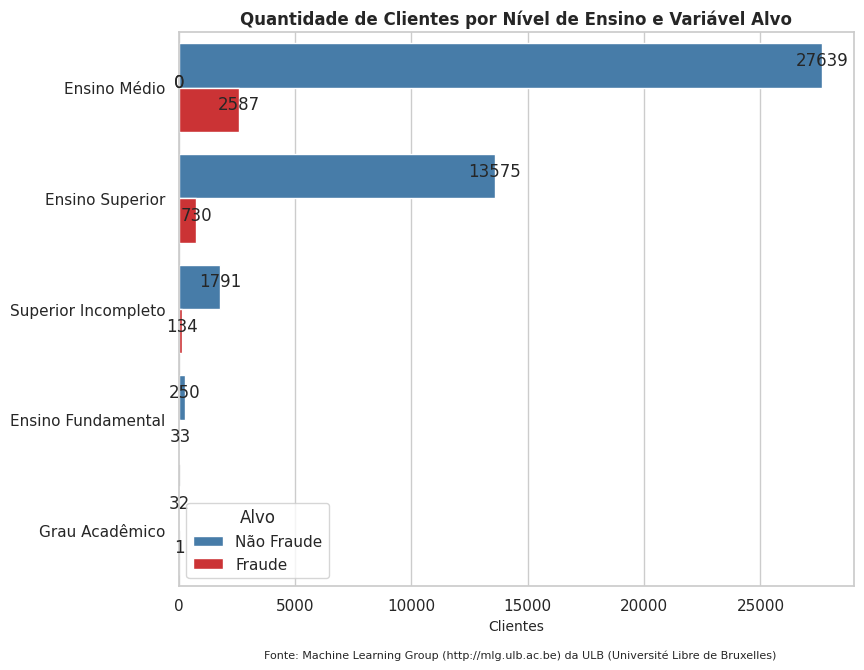

In [75]:
# Gráfico de Clientes por Nível de Ensino e Variável Alvo

fig, ax = plt.subplots(figsize=(8.8, 6.6))

label_map = {
    'ensino_medio': 'Ensino Médio',
    'ensino_superior': 'Ensino Superior',
    'superior_incompleto': 'Superior Incompleto',
    'ensino_fundamental': 'Ensino Fundamental',
    'grau_academico': 'Grau Acadêmico'}

labels = [label_map.get(category) for category in atual_dados2['NIVEL_EDU'].unique()]

# Invertendo a ordem das cores na paleta Set1
custom_palette = sns.color_palette("Set1", n_colors=2)[::-1]

ax = sns.countplot(y="NIVEL_EDU", hue="ALVO", data=atual_dados2, palette=custom_palette)

ax.set_yticklabels(labels)

for p in ax.patches:
    ax.annotate(format(p.get_width(), '.0f'), (p.get_width() + 10, p.get_y() + p.get_height() / 2), ha='center', fontsize=12)

# Título do gráfico
plt.title("Quantidade de Clientes por Nível de Ensino e Variável Alvo", fontsize=12, fontweight='bold')
plt.xlabel("Clientes", fontsize=10)
plt.ylabel("", fontsize=10)

# Adicionando a legenda
plt.legend(title="Alvo", labels=["Não Fraude", "Fraude"])

# Fonte do gráfico
plt.figtext(0.6, -0.01, "Fonte: Machine Learning Group (http://mlg.ulb.ac.be) da ULB (Université Libre de Bruxelles)", wrap=True, horizontalalignment='center', fontsize=8)

plt.tight_layout()

#salvando gráfico
#plt.savefig('Grafico_Quantidade_Clientes_Escolaridade_Alvo.png', dpi=300, bbox_inches='tight')

plt.show()

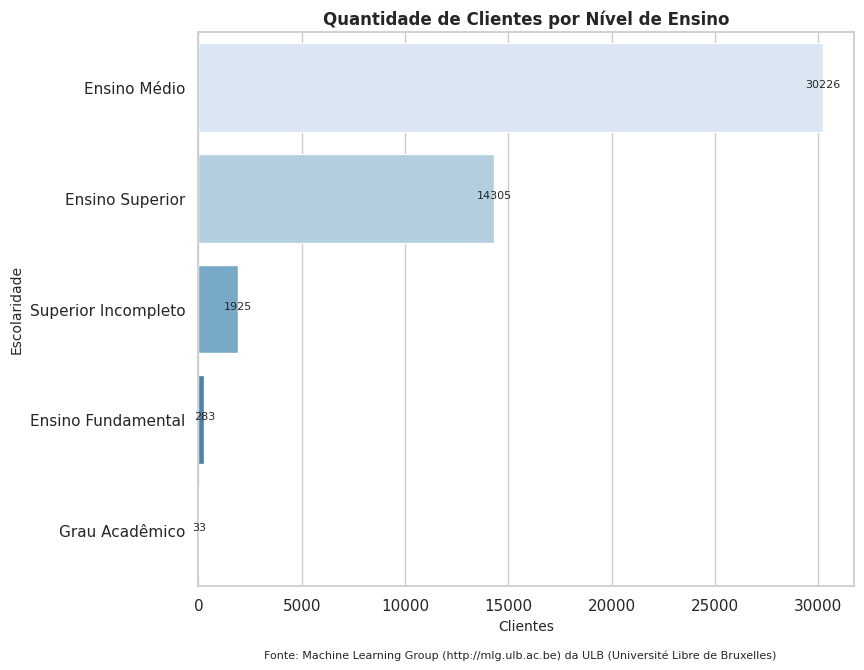

In [76]:
# Gráfico de Clientes por Nível de Ensino

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8.8, 6.6))

label_map = {
    'ensino_medio': 'Ensino Médio',
    'ensino_superior': 'Ensino Superior',
    'superior_incompleto': 'Superior Incompleto',
    'ensino_fundamental': 'Ensino Fundamental',
    'grau_academico': 'Grau Acadêmico'}

labels = [label_map.get(category) for category in atual_dados2['NIVEL_EDU'].unique()]

ax = sns.countplot(y="NIVEL_EDU", data=atual_dados2, palette="Blues")

ax.set_yticklabels(labels)

for p in ax.patches:
    ax.annotate(format(p.get_width(), '.0f'), (p.get_width() + 10, p.get_y() + p.get_height() / 2), ha='center', fontsize=8)

# Título do gráfico
plt.title("Quantidade de Clientes por Nível de Ensino", fontsize=12, fontweight='bold')
plt.xlabel("Clientes", fontsize=10)
plt.ylabel("Escolaridade", fontsize=10)

# Fonte do gráfico
plt.figtext(0.6, -0.01, "Fonte: Machine Learning Group (http://mlg.ulb.ac.be) da ULB (Université Libre de Bruxelles)", wrap=True, horizontalalignment='center', fontsize=8)

plt.tight_layout()

# Salvando gráfico
#plt.savefig('Grafico_Quantidade_Clientes_Escolaridade.png', dpi=300, bbox_inches='tight')


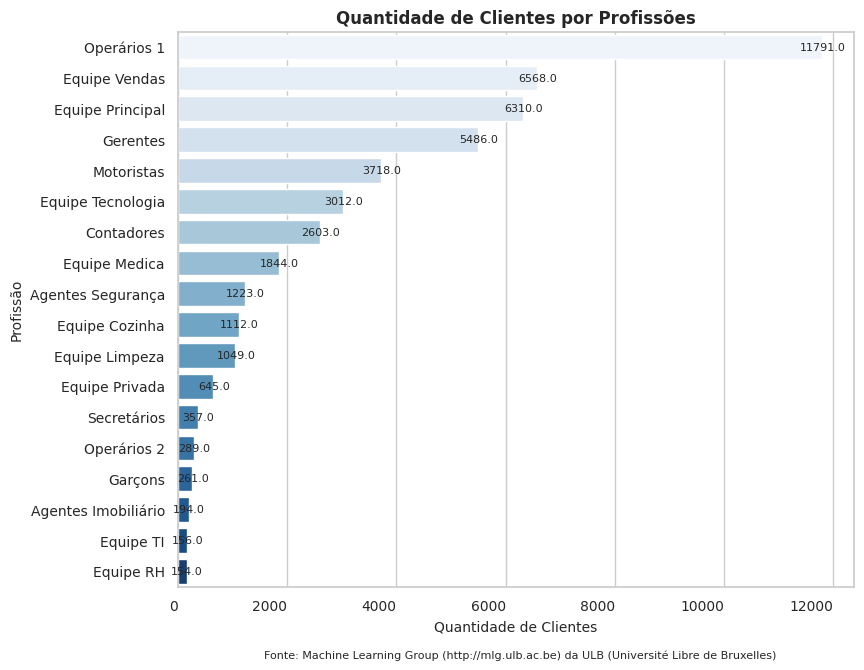

In [77]:
# Gráfico de Cliente por Profissão

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8.8, 6.6))

# Renomeando as categorias da variável PROFISSAO
profissoes_renomeadas = atual_dados2['PROFISSAO'].replace({
    'operario': 'Operários 1',
    'equipe_vendas': 'Equipe Vendas',
    'equipe_principal': 'Equipe Principal',
    'gerente': 'Gerentes',
    'motorista': 'Motoristas',
    'equipe_tecnologia': 'Equipe Tecnologia',
    'contador': 'Contadores',
    'equipe_medica': 'Equipe Medica',
    'agente_seguranca': 'Agentes Segurança',
    'equipe_cozinha': 'Equipe Cozinha',
    'equipe_limpeza': 'Equipe Limpeza',
    'equipe_privada': 'Equipe Privada',
    'secretario': 'Secretários',
    'operario_0': 'Operários 2',
    'garcon': 'Garçons',
    'agente_imobiliario': 'Agentes Imobiliário',
    'equipe_ti': 'Equipe TI',
    'equipe_rh': 'Equipe RH'})

# Ordenando as barras em ordem decrescente
profissao_counts = profissoes_renomeadas.value_counts()
ax = sns.countplot(y=profissoes_renomeadas, order=profissao_counts.index, palette="Blues")

# Rotulando as barras
for p in ax.patches:
    width = p.get_width()
    plt.text(width + 10, p.get_y() + p.get_height() / 2, f"{width}", ha='center', va='center', fontsize=8)

# Título do gráfico
plt.title("Quantidade de Clientes por Profissões", fontsize=12, fontweight='bold')
plt.xlabel("Quantidade de Clientes", fontsize=10)
plt.ylabel("Profissão", fontsize=10)

# Ajustando o tamanho das fontes
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Rotacionando os rótulos do eixo y, se necessário
plt.xticks(rotation=0, ha='right')

# Fonte do gráfico
plt.figtext(0.6, -0.01, "Fonte: Machine Learning Group (http://mlg.ulb.ac.be) da ULB (Université Libre de Bruxelles)", wrap=True, horizontalalignment='center', fontsize=8)

plt.tight_layout()
# Salvando gráfico
#plt.savefig('Grafico_Quantidade_Clientes_Profissoes.png', dpi=300, bbox_inches='tight')


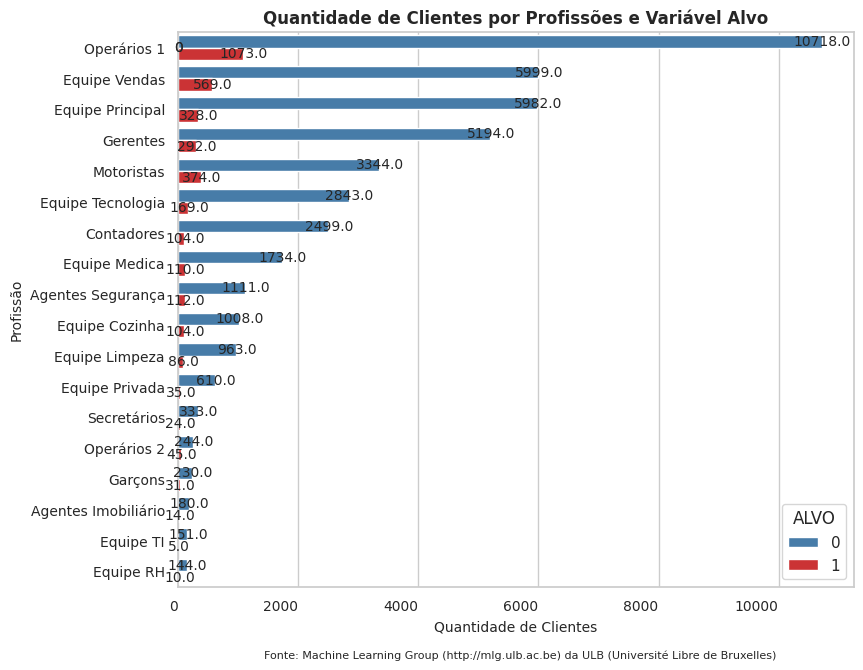

In [78]:
# Gráfico Quantidade de Clientes por Profissão e Variável Alvo

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8.8, 6.6))

# Renomeando as categorias da variável PROFISSAO
profissoes_renomeadas = atual_dados2['PROFISSAO'].replace({
    'operario': 'Operários 1',
    'equipe_vendas': 'Equipe Vendas',
    'equipe_principal': 'Equipe Principal',
    'gerente': 'Gerentes',
    'motorista': 'Motoristas',
    'equipe_tecnologia': 'Equipe Tecnologia',
    'contador': 'Contadores',
    'equipe_medica': 'Equipe Medica',
    'agente_seguranca': 'Agentes Segurança',
    'equipe_cozinha': 'Equipe Cozinha',
    'equipe_limpeza': 'Equipe Limpeza',
    'equipe_privada': 'Equipe Privada',
    'secretario': 'Secretários',
    'operario_0': 'Operários 2',
    'garcon': 'Garçons',
    'agente_imobiliario': 'Agentes Imobiliário',
    'equipe_ti': 'Equipe TI',
    'equipe_rh': 'Equipe RH'})

# Ordenando as barras em ordem decrescente
profissao_counts = profissoes_renomeadas.value_counts()

# Invertendo a ordem das cores na paleta Set1
custom_palette = sns.color_palette("Set1", n_colors=2)[::-1]

ax = sns.countplot(y=profissoes_renomeadas, hue=atual_dados2['ALVO'], order=profissao_counts.index, palette=custom_palette)

# Rotulando as barras
for p in ax.patches:
    width = p.get_width()
    plt.text(width + 10, p.get_y() + p.get_height() / 2, f"{width}", ha='center', va='center', fontsize=10)

# Título do gráfico
plt.title("Quantidade de Clientes por Profissões e Variável Alvo", fontsize=12, fontweight='bold')
plt.xlabel("Quantidade de Clientes", fontsize=10)
plt.ylabel("Profissão", fontsize=10)

# Ajustando o tamanho das fontes
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Rotacionando os rótulos do eixo y, se necessário
plt.xticks(rotation=0, ha='right')

# Fonte do gráfico
plt.figtext(0.6, -0.01, "Fonte: Machine Learning Group (http://mlg.ulb.ac.be) da ULB (Université Libre de Bruxelles)", wrap=True, horizontalalignment='center', fontsize=8)

plt.tight_layout()
# Salvando o gráfico
#plt.savefig('Grafico_Quantidade_Clientes_Profissoes_Alvo.png', dpi=300, bbox_inches='tight')

plt.show()


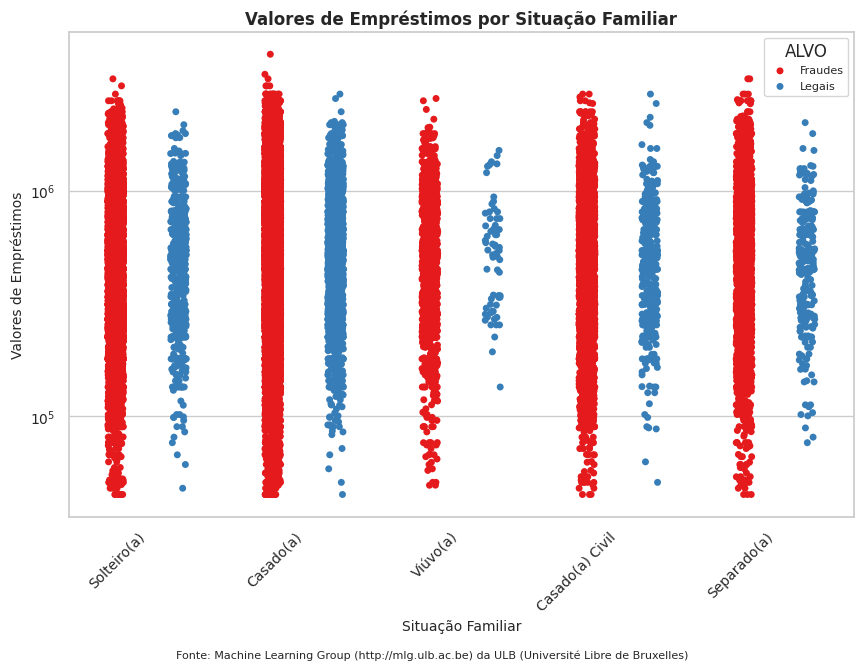

In [79]:
# Gráfico Valores de Empréstimos por Situação Familiar

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8.8, 6.6))

# Renomeando as categorias da variável SIT_FAMILIAR
sit_familiar_renomeada = atual_dados2['SIT_FAMILIAR'].replace({
    'solteiro': 'Solteiro(a)',
    'casado': 'Casado(a)',
    'viuva': 'Viúvo(a)',
    'casado_civil': 'Casado(a) Civil',
    'separado': 'Separado(a)'})

# Ajustando a escala do eixo y
plt.yscale('log')  # ou 'linear', dependendo dos dados

# Plotando o gráfico de stripplot
splot = sns.stripplot(y="VALOR_EMPRESTIMO", x=sit_familiar_renomeada, hue="ALVO", data=atual_dados2, dodge=True, palette="Set1")

# Título do gráfico
plt.title("Valores de Empréstimos por Situação Familiar", fontsize=12, fontweight='bold')
plt.xlabel("Situação Familiar", fontsize=10)
plt.ylabel("Valores de Empréstimos", fontsize=10)

# Ajustando o tamanho das fontes
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Rotacionando os rótulos do eixo x, se necessário
plt.xticks(rotation=45, ha='right')

# Adicionando legenda
plt.legend(title="ALVO", labels=["Fraudes", "Legais"], fontsize=8)

# Fonte do gráfico
plt.figtext(0.5, -0.01, "Fonte: Machine Learning Group (http://mlg.ulb.ac.be) da ULB (Université Libre de Bruxelles)", wrap=True, horizontalalignment='center', fontsize=8)

plt.tight_layout()
# Salvando gráfico
#plt.savefig('Grafico_SituacaoFamiliar_ValorEmprestimo_Sexo.png', dpi=300, bbox_inches='tight')

plt.show()


### Análisde descritiva Finanças


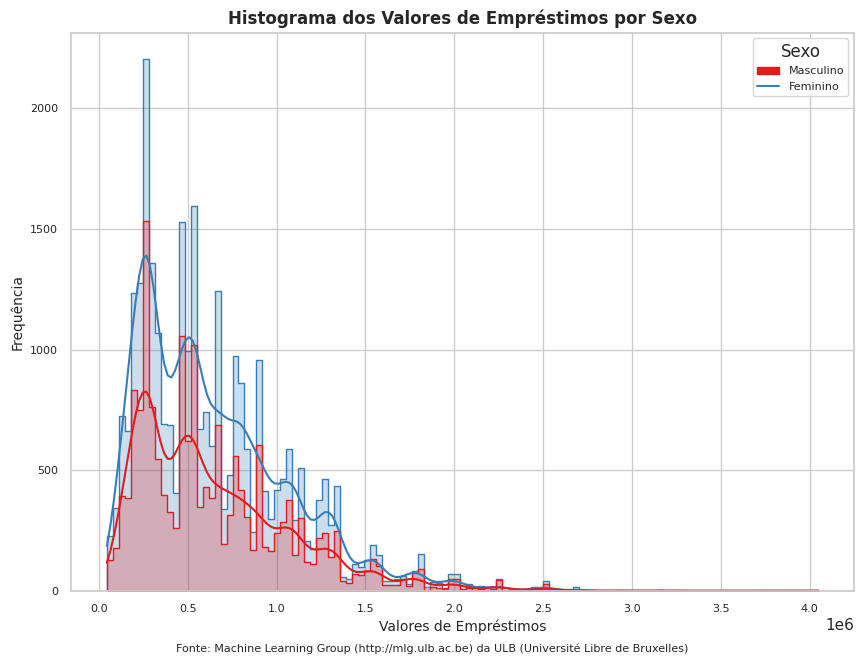

In [80]:
# Gráfico Valores de Empréstimo por Sexo

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8.8, 6.6))

sns.histplot(x="VALOR_EMPRESTIMO",
             kde=True,
             hue="GENERO",
             data=atual_dados2,
             palette="Set1",  # Utilizar as cores da paleta Set1 para as barras e a legenda
             element="step")  # Definir o estilo das barras

legend_labels = ["Masculino", "Feminino"]
legend = plt.legend(title="Sexo", labels=legend_labels, fontsize=8)

# Definindo as cores dos rótulos na legenda usando a paleta Set1
for handle, color in zip(legend.legendHandles, sns.color_palette("Set1")):
    handle.set_color(color)

# Título do gráfico
plt.title("Histograma dos Valores de Empréstimos por Sexo", fontsize=12, fontweight='bold')
plt.xlabel("Valores de Empréstimos", fontsize=10)
plt.ylabel("Frequência", fontsize=10)

# Ajustando o tamanho das fontes
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Fonte do gráfico
plt.figtext(0.5, -0.00001, "Fonte: Machine Learning Group (http://mlg.ulb.ac.be) da ULB (Université Libre de Bruxelles)", wrap=True, horizontalalignment='center', fontsize=8)

plt.tight_layout()
# Salvando o gráfico
#plt.savefig('Grafico_ValoresEmprestimos_Sexo.png', dpi=300)

plt.show()


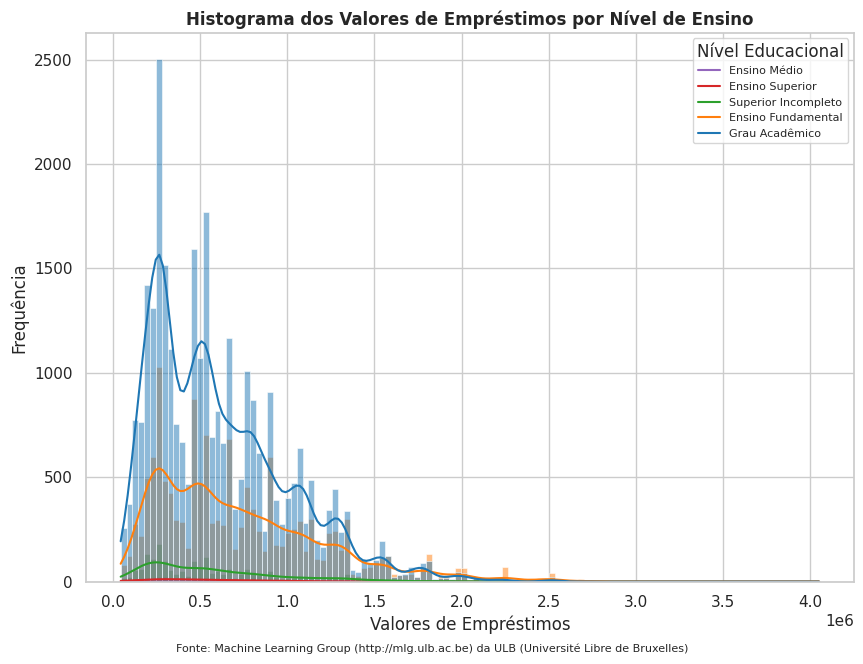

In [81]:
# Gráfico de Valores de Empréstimos por Nível de Ensino

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8.8, 6.6))

sns.histplot(x="VALOR_EMPRESTIMO",
             kde=True,
             hue="NIVEL_EDU",
             data=atual_dados2,
             palette=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"])

label_map = {
    'ensino_medio': 'Ensino Médio',
    'ensino_superior': 'Ensino Superior',
    'superior_incompleto': 'Superior Incompleto',
    'ensino_fundamental': 'Ensino Fundamental',
    'grau_academico': 'Grau Acadêmico'}

# Adicionando a legenda
labels = [label_map.get(category) for category in atual_dados2['NIVEL_EDU'].unique()]
plt.legend(title="Nível Educacional", labels=labels, fontsize=8)

# Título do gráfico
plt.title("Histograma dos Valores de Empréstimos por Nível de Ensino", fontsize=12, fontweight='bold')
plt.xlabel("Valores de Empréstimos")
plt.ylabel("Frequência")

# Fonte do gráfico
plt.figtext(0.5, -0.00001, "Fonte: Machine Learning Group (http://mlg.ulb.ac.be) da ULB (Université Libre de Bruxelles)", wrap=True, horizontalalignment='center', fontsize=8)

plt.tight_layout()

# Salvando gráfico
#plt.savefig('Grafico_ValoresEmpréstimos_por_Nível_Ensino.png', dpi=300)


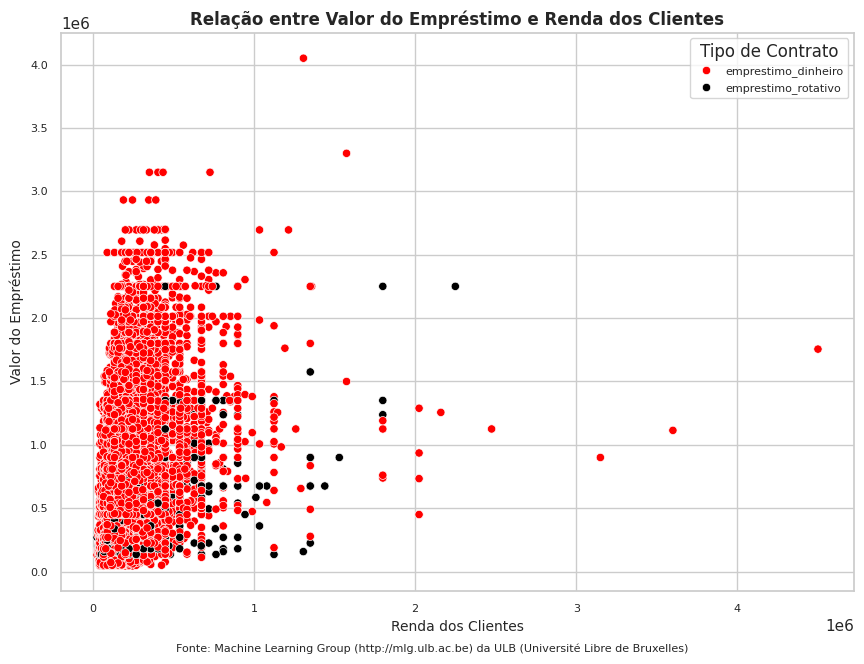

In [82]:
# Gráfico Relação entre Valor do Empréstimo e Renda dos Clientes

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8.8, 6.6))

graf_disp = sns.scatterplot(data=atual_dados2,
                            x="RENDA_CLIENTE",
                            y="VALOR_EMPRESTIMO",
                            hue="NOME_TIPO_CONTRATO",
                            palette=["red", "black"],
                            legend="full")

# Ajustando o tamanho da legenda
plt.legend(title="Tipo de Contrato", fontsize=8)

# Ajustando o tamanho das marcações no gráfico
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Título do gráfico
plt.title("Relação entre Valor do Empréstimo e Renda dos Clientes", fontsize=12, fontweight='bold')
plt.xlabel("Renda dos Clientes", fontsize=10)
plt.ylabel("Valor do Empréstimo", fontsize=10)

# Fonte do gráfico
plt.figtext(0.5, -0.00001, "Fonte: Machine Learning Group (http://mlg.ulb.ac.be) da ULB (Université Libre de Bruxelles)", wrap=True, horizontalalignment='center', fontsize=8)

plt.tight_layout()

# Salvando gráfico
#plt.savefig('Grafico_Relacao_Valor_Emprestimo_Renda_Clientes.png', dpi=300)


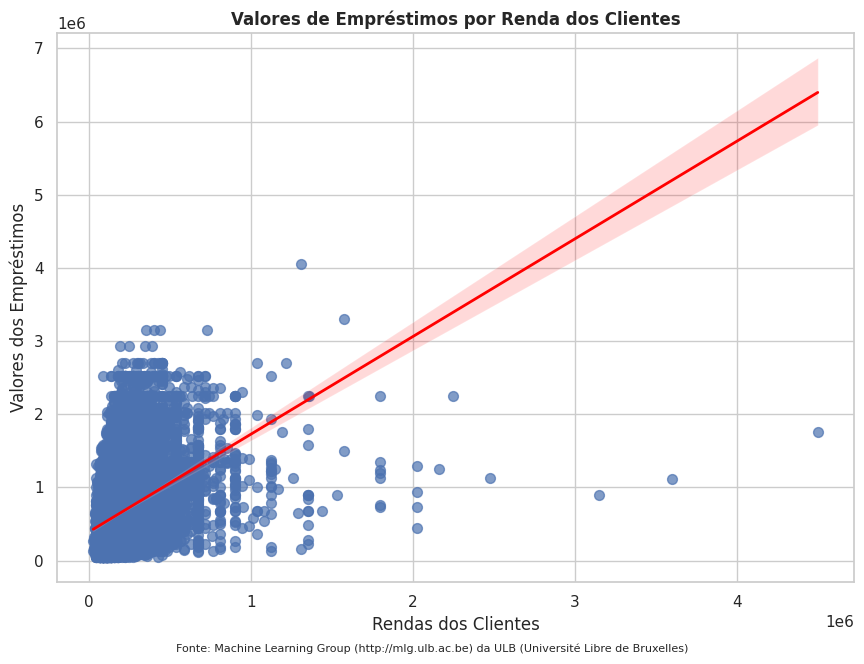

In [83]:
# Gráfico Valores de Empréstimos por Renda dos Clientes

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(8.8, 6.6))

sns.regplot(data=atual_dados2,
            x="RENDA_CLIENTE",
            y="VALOR_EMPRESTIMO",
            scatter_kws={"alpha": 0.7, "s": 50},
            line_kws={"color": "red", "lw": 2})

# Título do gráfico
plt.title("Valores de Empréstimos por Renda dos Clientes", fontsize=12, fontweight='bold')
plt.xlabel("Rendas dos Clientes")
plt.ylabel("Valores dos Empréstimos")

# Fonte do gráfico
plt.figtext(0.5, -0.00001, "Fonte: Machine Learning Group (http://mlg.ulb.ac.be) da ULB (Université Libre de Bruxelles)", wrap=True, horizontalalignment='center', fontsize=8)


plt.tight_layout()

# Salvando Gráfico de Valores de Empréstimos por Renda dos Clientes
#plt.savefig('Grafico_ValoresEmprestimos_RendasClientes.png', dpi=300)

plt.show()


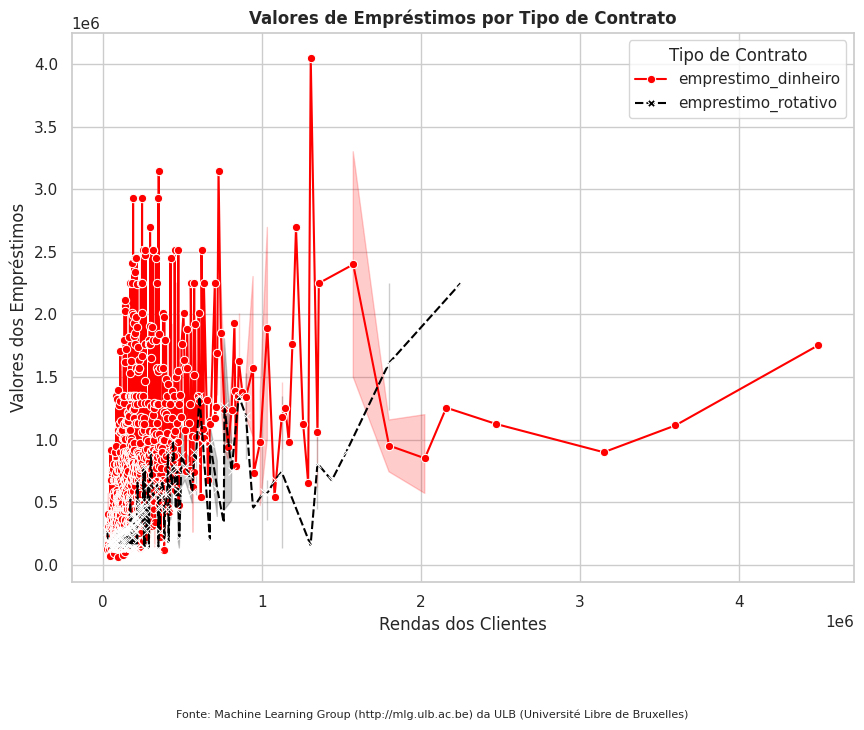

In [84]:
# Gráfico de Valores de Emprétimos por Tipo de Contrato

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(8.8, 6.6))

sns.lineplot(data=atual_dados2,
             x="RENDA_CLIENTE",
             y="VALOR_EMPRESTIMO",
             hue="NOME_TIPO_CONTRATO",
             style="NOME_TIPO_CONTRATO",
             markers=True,
             palette=["red", "black"],
             legend="full")

# Definindo rótulos para os marcadores
legend_labels = ['Contrato 1', 'Contrato 2']
ax.lines[0].set_marker('o')
ax.lines[1].set_marker('x')
ax.legend(title='Tipo de Contrato', loc='upper right')

# Título do gráfico
plt.title("Valores de Empréstimos por Tipo de Contrato", fontsize=12, fontweight='bold')
plt.xlabel("Rendas dos Clientes")
plt.ylabel("Valores dos Empréstimos")

# Fonte do gráfico
plt.figtext(0.5, -0.1, "Fonte: Machine Learning Group (http://mlg.ulb.ac.be) da ULB (Université Libre de Bruxelles)", wrap=True, horizontalalignment='center', fontsize=8)

plt.tight_layout()

# Salvando gráfico
#plt.savefig('Grafico_ValoresEmprestimos_RendasClientes.png', dpi=300)

plt.show()


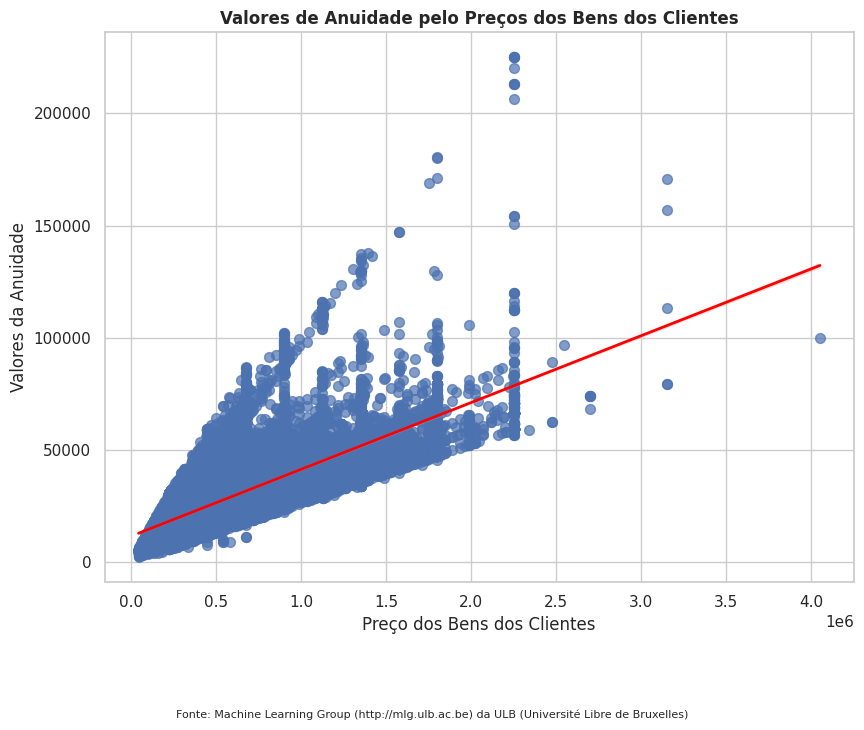

In [85]:
# Gráfico Valores de Anuidade pelo Preços de Bens dos Clientes

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(8.8, 6.6))

sns.regplot(data=atual_dados2,
            x="PRECO_BENS",
            y="ANUIDADE_EMPRESTIMO",
            scatter_kws={"alpha": 0.7, "s": 50},
            line_kws={"color": "red", "lw": 2})

# Título do gráfico
plt.title("Valores de Anuidade pelo Preços dos Bens dos Clientes", fontsize=12, fontweight='bold')
plt.xlabel("Preço dos Bens dos Clientes")
plt.ylabel("Valores da Anuidade")

# Fonte do gráfico
plt.figtext(0.5, -0.1, "Fonte: Machine Learning Group (http://mlg.ulb.ac.be) da ULB (Université Libre de Bruxelles)", wrap=True, horizontalalignment='center', fontsize=8)

plt.tight_layout()
plt.savefig('Grafico_ValoresAnuidade_PrecoBens.png', dpi=300)
plt.show()


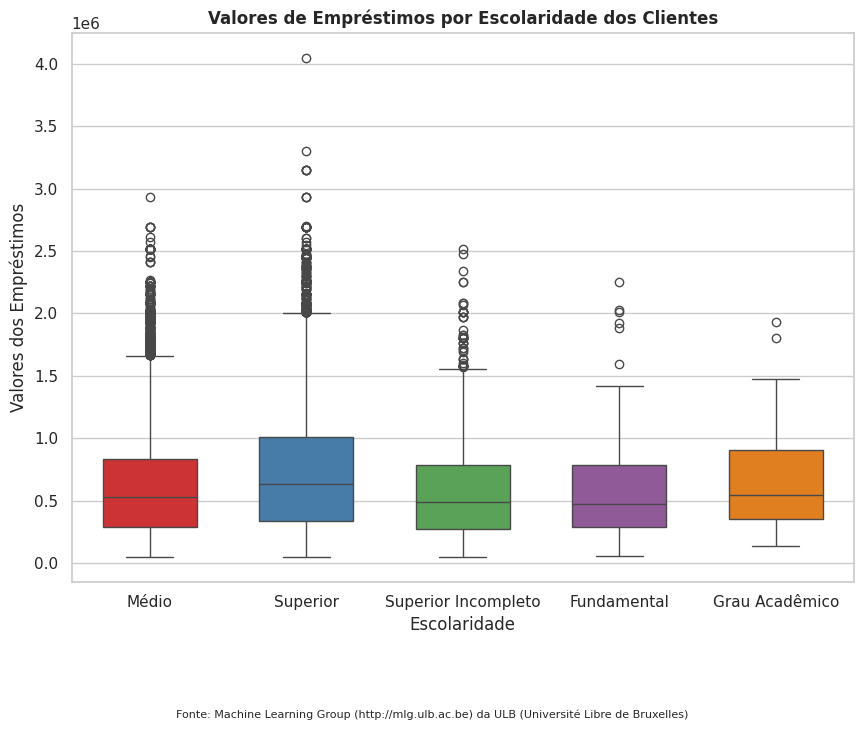

In [86]:
# Gráfico Valores de Empréstimos por Escolaridade dos Clientes

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(8.8, 6.6))

label_map = {
    'ensino_medio': 'Médio',
    'ensino_superior': 'Superior',
    'superior_incompleto': 'Superior Incompleto',
    'ensino_fundamental': 'Fundamental',
    'grau_academico': 'Grau Acadêmico'}

labels = [label_map.get(category) for category in atual_dados2['NIVEL_EDU'].unique()]

ax = sns.boxplot(y="VALOR_EMPRESTIMO",
                 x="NIVEL_EDU",
                 data=atual_dados2,
                 width=0.6,
                 palette="Set1")
ax.set_xticklabels(labels)  # Definindo os rótulos para o eixo x

# Título do gráfico
plt.title("Valores de Empréstimos por Escolaridade dos Clientes", fontsize=12, fontweight='bold')
plt.xlabel("Escolaridade")
plt.ylabel("Valores dos Empréstimos")

# Fonte do gráfico
plt.figtext(0.5, -0.1, "Fonte: Machine Learning Group (http://mlg.ulb.ac.be) da ULB (Université Libre de Bruxelles)", wrap=True, horizontalalignment='center', fontsize=8)

plt.tight_layout()
# Salvando o gráfico
#plt.savefig('Grafico_ValoresEmprestimos_Escolaridade.png', dpi=300)

plt.show()


### Análise Descritiva e Exploratória

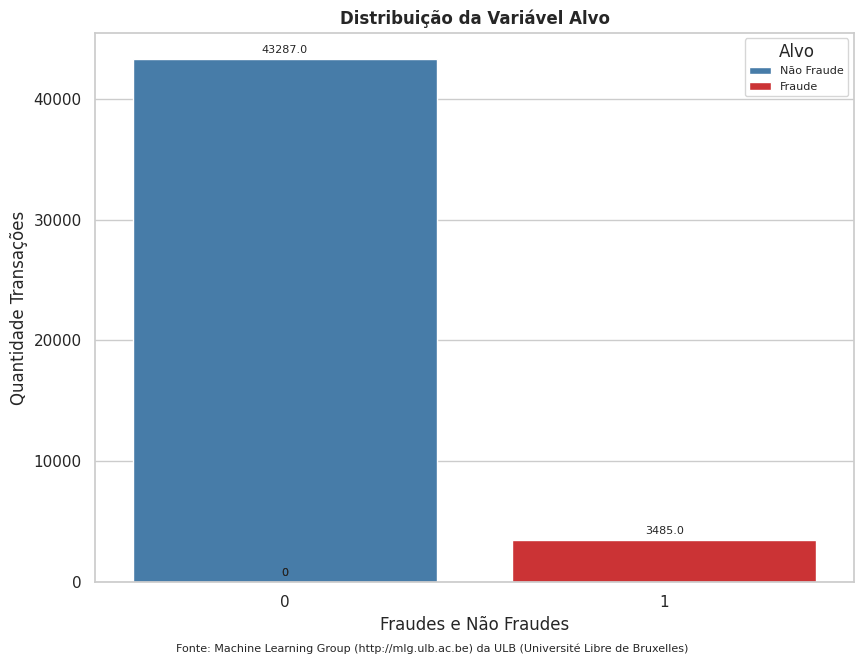

In [87]:
# Análise de dados considerados fraudes na amostra com todas linhas com dados faltantes retirados, dados desbalanceados

# Gráfico da Distribuição da Variável Alvo

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8.8, 6.6))
custom_palette = sns.color_palette("Set1", n_colors=2)[::-1]
sns.countplot(x="ALVO",
              hue='ALVO',
              dodge=False,
              palette= custom_palette,
              data=atual_dados2)

# Título do gráfico
plt.title("Distribuição da Variável Alvo", fontsize=12, fontweight='bold')
plt.ylabel("Quantidade Transações")
plt.xlabel("Fraudes e Não Fraudes")

# Adicionando legenda
legend_labels = ["Não Fraude", "Fraude"]
legend = plt.legend(title="Alvo", labels=legend_labels, fontsize=8)

# Fonte do gráfico
plt.figtext(0.5, 0, "Fonte: Machine Learning Group (http://mlg.ulb.ac.be) da ULB (Université Libre de Bruxelles)", wrap=True, horizontalalignment='center', fontsize=8)

# Adicionando rótulos nas barras
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}',
                xy=(p.get_x() + p.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8)
plt.tight_layout()

# Salvando gráfico
#plt.savefig('Grafico_Distribuicao_Variavel_Alvo1.png', dpi=300)
plt.show()


#OBS: A partir dessas informações, vemos que este é um conjunto de dados desequilibrado. Existe muito mais emprestimos
# que foram pagos no prazo, do que os que não foram pagos.
# No banco como um todo foram mais de 25.000 emprestimos reelbolsados, e menos de 2500 emprestimos atrasaram por
# algum motivo e não foram pagos.


### Análise Descritiva e Exploratória EDA

In [88]:
# Opção de uma análise rápida automática
#ADE = create_report(atual_dados2, title='My Report')
#ADE

In [89]:
atual_dados2 = pd.get_dummies(atual_dados2)

In [90]:
atual_dados2.tail(10)

,Id_EMPRESTIMO,ALVO,CARRO,CASA_APART,QTD_FILHOS,RENDA_CLIENTE,VALOR_EMPRESTIMO,ANUIDADE_EMPRESTIMO,PRECO_BENS,REGIAO_POPULACAO_RELATIVE,...,HOUSETYPE_MODE_bloco_apartamento,HOUSETYPE_MODE_casa_terraco,HOUSETYPE_MODE_habitacao_especifica,WALLSMATERIAL_MODE_bloco,WALLSMATERIAL_MODE_madeira,WALLSMATERIAL_MODE_misto,WALLSMATERIAL_MODE_monolitico,WALLSMATERIAL_MODE_outros,WALLSMATERIAL_MODE_painel,WALLSMATERIAL_MODE_tijolo_pedra
307437,456175,0,1,1,0,81000.0,180000.0,12658.5,180000.0,0.015221,...,1,0,0,0,0,0,0,0,1,0
307438,456176,1,0,1,0,171000.0,1436850.0,42142.5,1125000.0,0.032561,...,1,0,0,0,0,0,0,0,0,1
307439,456177,0,0,1,0,247500.0,900000.0,50386.5,900000.0,0.010006,...,1,0,0,0,0,0,0,0,1,0
307448,456186,1,0,0,1,207000.0,450000.0,32746.5,450000.0,0.020246,...,1,0,0,0,0,0,0,0,0,1
307454,456193,0,0,0,0,157500.0,1332000.0,39078.0,1332000.0,0.008575,...,1,0,0,0,0,0,0,0,0,1
307456,456195,0,1,1,0,94500.0,270000.0,15075.0,270000.0,0.028663,...,1,0,0,0,0,0,0,0,0,1
307462,456201,0,1,1,3,135000.0,1024785.0,57222.0,922500.0,0.008019,...,1,0,0,0,0,0,0,0,0,1
307465,456205,0,0,0,1,180000.0,835380.0,33259.5,675000.0,0.031329,...,1,0,0,1,0,0,0,0,0,0
307482,456226,0,1,1,0,225000.0,500566.5,34969.5,472500.0,0.031329,...,1,0,0,1,0,0,0,0,0,0
307489,456233,1,0,1,0,225000.0,521280.0,23089.5,450000.0,0.014464,...,1,0,0,0,0,0,0,0,0,1


In [91]:
print(sorted(Counter(atual_dados2['ALVO']).items()))

[(0, 43287), (1, 3485)]


In [92]:
# Separando Variáveis explicativas da variável ALVO

dataset_stellar = atual_dados2
a = dataset_stellar.loc[:, (dataset_stellar.columns != 'ALVO' ) & (dataset_stellar.columns != 'Id_EMPRESTIMO') ].values
b = dataset_stellar["ALVO"].values

### Balanceamento dos dados (Oversampling)




O balanceamento dos dados é uma técnica essencial em problemas de aprendizado de máquina, especialmente quando há um desequilíbrio significativo entre as classes do conjunto de dados. Neste resumo, abordaremos especificamente a técnica de oversampling, que consiste em aumentar a quantidade de amostras da classe minoritária para equilibrar as classes.

Oversampling como técnica de balanceamento:
O oversampling é uma abordagem amplamente utilizada para lidar com o desbalanceamento de classes. Essa técnica envolve a replicação ou criação de instâncias sintéticas da classe minoritária para aumentar sua representação no conjunto de dados. Ao fazer isso, busca-se mitigar os efeitos negativos do desequilíbrio de classes e melhorar o desempenho dos modelos de aprendizado de máquina.

In [93]:
%%capture
%%bash
pip install imbalanced-learn

In [94]:
from imblearn.over_sampling import RandomOverSampler

In [95]:
ros = RandomOverSampler (random_state = 0)
a_resampled, b_resampled = ros.fit_resample(a,b)
print(sorted(Counter(b_resampled).items()), b_resampled.shape)

[(0, 43287), (1, 43287)] (86574,)


In [96]:
a_resampled

array([[0., 1., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 1., 0.],
       ...,
       [1., 1., 0., ..., 0., 1., 0.],
       [0., 1., 1., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 1.]])

In [97]:
b_resampled

array([1, 0, 0, ..., 1, 1, 1])

In [98]:
# Criação de dataframe a partir do array de 0 e 1 balanceados para fazer o gráfico:
# Nomes das colunas
nomes_colunas = ['ALVO']

# Criação do DataFrame com os nomes das colunas
df = pd.DataFrame(b_resampled, columns=nomes_colunas)



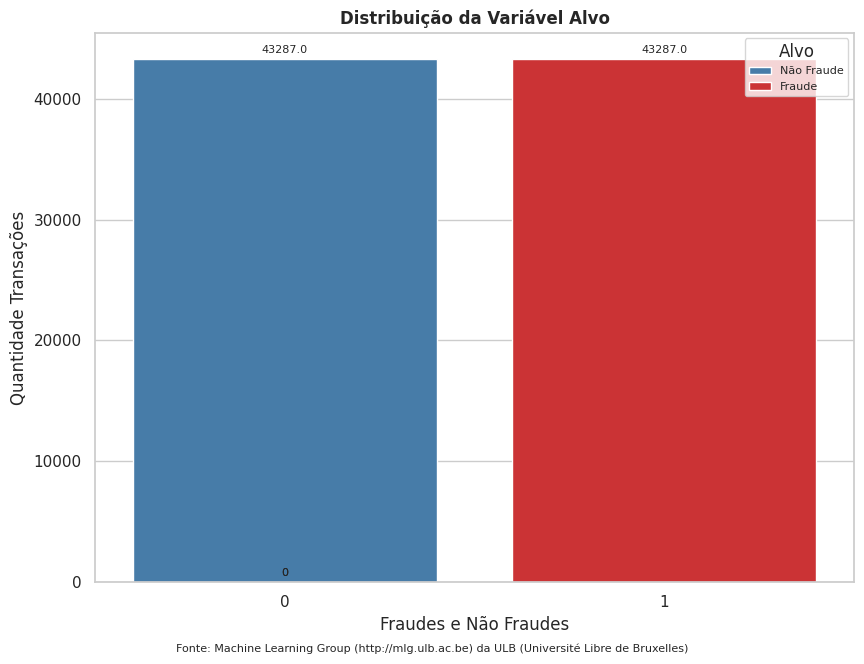

In [99]:
# Dados balanceados

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8.8, 6.6))
custom_palette = sns.color_palette("Set1", n_colors=2)[::-1]
sns.countplot(x="ALVO",
              hue='ALVO',
              dodge=False,
              palette=custom_palette,
              data=df)

# Título do gráfico
plt.title("Distribuição da Variável Alvo", fontsize=12, fontweight='bold')
plt.ylabel("Quantidade Transações")
plt.xlabel("Fraudes e Não Fraudes")

# Legenda gráfico
legend_labels = ["Não Fraude", "Fraude"]
legend = plt.legend(title="Alvo", labels=legend_labels, fontsize=8)

# Fonte gráfico
plt.figtext(0.5, 0, "Fonte: Machine Learning Group (http://mlg.ulb.ac.be) da ULB (Université Libre de Bruxelles)", wrap=True, horizontalalignment='center', fontsize=8)

# Adicionar rótulos nas barras
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}',
                xy=(p.get_x() + p.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()

# Salvando gráfico
#plt.savefig('Grafico_Distribuicao_Variavel_Alvo.png', dpi=300, bbox_inches='tight')

plt.show()

#OBS: A partir dessas informações, vemos que este é um conjunto de dados desequilibrado. Existe muito mais emprestimos
# que foram pagos no prazo, do que os que não foram pagos.
# No banco como um todo foram mais de 25.000 emprestimos reelbolsados, e menos de 2500 emprestimos atrasaram por
# algum motivo e não foram pagos.


### Normalização dos dados

A normalização de dados é uma etapa importante no pré-processamento de dados para modelagem, com o objetivo de garantir que todas as variáveis tenham a mesma escala e reduzir possíveis efeitos negativos de valores discrepantes ou variâncias desiguais entre as variáveis. A normalização é especialmente relevante em algoritmos sensíveis à escala dos dados, como aqueles baseados em distância.

In [100]:
# Normalização dos dados do tipo [variaveis continuas (float) e discreta (int)]

scale_obj = StandardScaler()
a_resampled = scale_obj.fit_transform(a_resampled.astype(float))
a_resampled = scale_obj.fit_transform(a_resampled.astype(int))

### Separação dos dados em treino e teste

In [101]:
# Separação dos dados já balanceados em treino e teste

XTrain, XTest, yTrain, yTest = train_test_split(a_resampled, b_resampled, test_size = 0.30)

## Algoritimos de Aprendizagem de Máquina (Classificadores)


### Máquina de vetores de suporte (Vetor Machine)

In [102]:
clf_svc = SVC()

In [103]:
clf_svc = clf_svc.fit(XTrain, yTrain)

Acuracia: 
0.8422977707619451

 Metricas de Classificação: 

              precision    recall  f1-score   support

           0       0.76      0.91      0.83     10997
           1       0.92      0.79      0.85     14976

    accuracy                           0.84     25973
   macro avg       0.84      0.85      0.84     25973
weighted avg       0.85      0.84      0.84     25973

Confusion Matrix: 

[[ 9978  1019]
 [ 3077 11899]]


Text(0.5, 1.0, 'Matriz de Confusão')

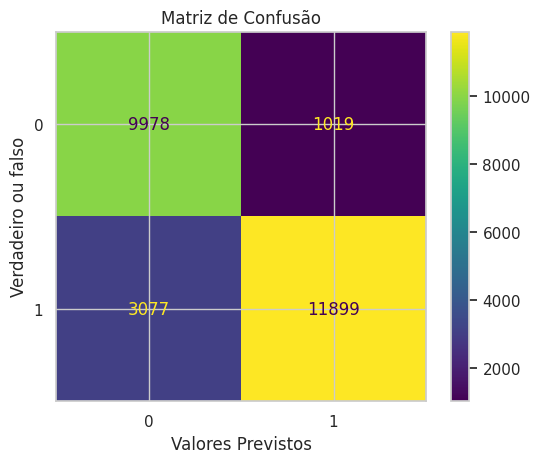

In [104]:
accuracy_svc = clf_svc.score(XTest, yTest)
print('Acuracia: \n' +str(accuracy_svc))
prediction_svc = clf_svc.predict(XTest)
cm_svc = confusion_matrix(prediction_svc, yTest)
cr_svc = classification_report(prediction_svc, yTest)
print('\n Metricas de Classificação: \n')
print(cr_svc)
print('Confusion Matrix: \n')
print(cm_svc)

splot = ConfusionMatrixDisplay.from_predictions(prediction_svc, yTest)

plt.xlabel("Valores Previstos")
plt.ylabel("Verdadeiro ou falso")
plt.title("Matriz de Confusão")


### Regressão Logística

In [105]:
clf_rl= LogisticRegression()

In [106]:
clf_rl = clf_rl.fit(XTrain, yTrain)

Acuracia: 
0.6283833211411851
Metricas de Classificação: 

              precision    recall  f1-score   support

           0       0.60      0.64      0.62     12219
           1       0.66      0.62      0.64     13754

    accuracy                           0.63     25973
   macro avg       0.63      0.63      0.63     25973
weighted avg       0.63      0.63      0.63     25973

Confusion Matrix: 

[[7811 4408]
 [5244 8510]]


Text(0.5, 1.0, 'Matriz de Confusão')

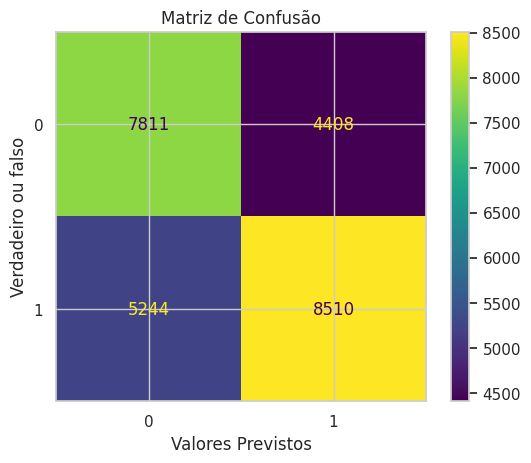

In [107]:
accuracy_rl = clf_rl.score(XTest, yTest)
print('Acuracia: \n' +str(accuracy_rl))
prediction_rl = clf_rl.predict(XTest)
cm_rl = confusion_matrix(prediction_rl, yTest)
cr_rl = classification_report(prediction_rl, yTest)
print('Metricas de Classificação: \n')
print(cr_rl)
print('Confusion Matrix: \n')
print(cm_rl)
splot = ConfusionMatrixDisplay.from_predictions(prediction_rl, yTest)
plt.xlabel("Valores Previstos")
plt.ylabel("Verdadeiro ou falso")
plt.title("Matriz de Confusão")


### Árvore de decisão (Decision tree learning)

In [108]:
clf_dtl = DecisionTreeClassifier ()

In [109]:
clf_dtl = clf_dtl.fit(XTrain, yTrain)

Acuracia: 
0.9372810226003927
Metricas de Classificação: 

              precision    recall  f1-score   support

           0       0.88      1.00      0.93     11426
           1       1.00      0.89      0.94     14547

    accuracy                           0.94     25973
   macro avg       0.94      0.94      0.94     25973
weighted avg       0.95      0.94      0.94     25973

Confusion Matrix: 

[[11426     0]
 [ 1629 12918]]


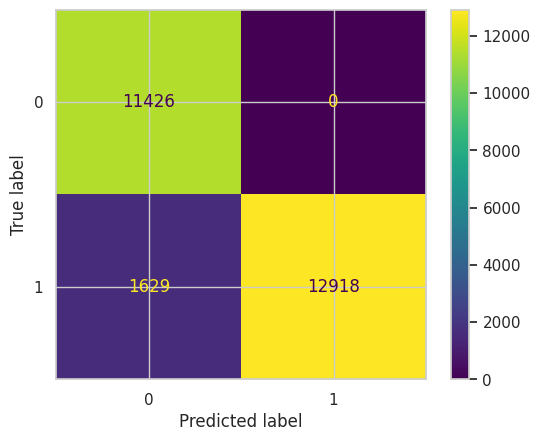

In [110]:
accuracy_dtl = clf_dtl.score(XTest, yTest)
print('Acuracia: \n' +str(accuracy_dtl))

prediction_dtl = clf_dtl.predict(XTest)
cm_dtl = confusion_matrix(prediction_dtl, yTest)
cr_dtl = classification_report(prediction_dtl, yTest)
print('Metricas de Classificação: \n')
print(cr_dtl)
print('Confusion Matrix: \n')
print(cm_dtl)
ConfusionMatrixDisplay.from_predictions(prediction_dtl, yTest)

### KNN - K-ésimo Vizinho mais Próximo (k-nearest neighbors algorithm)

In [111]:
clf_knn = KNeighborsClassifier()

In [112]:
clf_knn = clf_knn.fit(XTrain, yTrain)

Acuracia: 
0.8576983790859739
Metricas de Classificação: 

              precision    recall  f1-score   support

           0       0.72      0.99      0.84      9525
           1       0.99      0.78      0.87     16448

    accuracy                           0.86     25973
   macro avg       0.86      0.89      0.86     25973
weighted avg       0.89      0.86      0.86     25973

Confusion Matrix: 

[[ 9442    83]
 [ 3613 12835]]


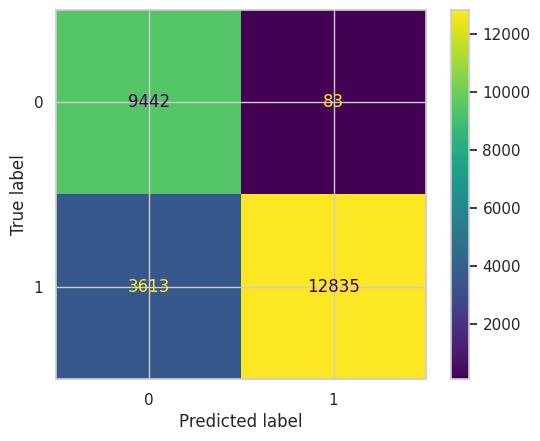

In [113]:
accuracy_knn = clf_knn.score(XTest, yTest)
print('Acuracia: \n' +str(accuracy_knn))
prediction_knn = clf_knn.predict(XTest)
cm_knn = confusion_matrix(prediction_knn, yTest)
cr_knn = classification_report(prediction_knn, yTest)
print('Metricas de Classificação: \n')
print(cr_knn)
print('Confusion Matrix: \n')
print(cm_knn)
ConfusionMatrixDisplay.from_predictions(prediction_knn, yTest)

### MLP Classifier - Perceptron multicamadas (Multilayer perceptron)


In [114]:
clf_mlp = MLPClassifier()

In [115]:
clf_mlp = clf_mlp.fit(XTrain, yTrain)

Acuracia: 
0.9455203480537481
Metricas de Classificação: 

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     11640
           1       1.00      0.90      0.95     14333

    accuracy                           0.95     25973
   macro avg       0.95      0.95      0.95     25973
weighted avg       0.95      0.95      0.95     25973

Confusion Matrix: 

[[11640     0]
 [ 1415 12918]]


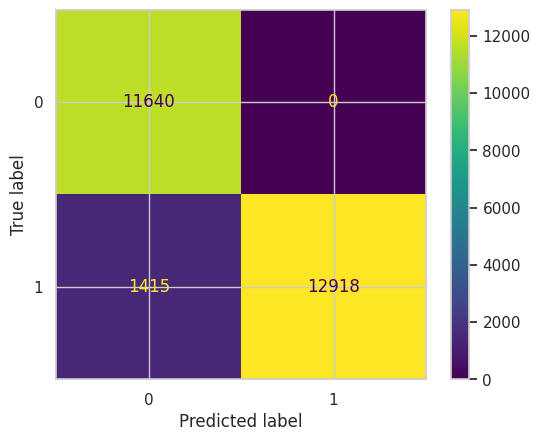

In [116]:
accuracy_mlp = clf_mlp.score(XTest, yTest)
print('Acuracia: \n' +str(accuracy_mlp))

prediction_mlp = clf_mlp.predict(XTest)
cm_mlp = confusion_matrix(prediction_mlp, yTest)
cr_mlp = classification_report(prediction_mlp, yTest)
print('Metricas de Classificação: \n')
print(cr_mlp)
print('Confusion Matrix: \n')
print(cm_mlp)
ConfusionMatrixDisplay.from_predictions(prediction_mlp, yTest)

### Floresta Aleatória (Random forest)

In [117]:
clf_rf = RandomForestClassifier()

In [118]:
clf_rf = clf_rf.fit(XTrain, yTrain)

Acuracia: 
0.9990759635005583
Metricas de Classificação: 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13031
           1       1.00      1.00      1.00     12942

    accuracy                           1.00     25973
   macro avg       1.00      1.00      1.00     25973
weighted avg       1.00      1.00      1.00     25973

Confusion Matrix: 

[[13031     0]
 [   24 12918]]


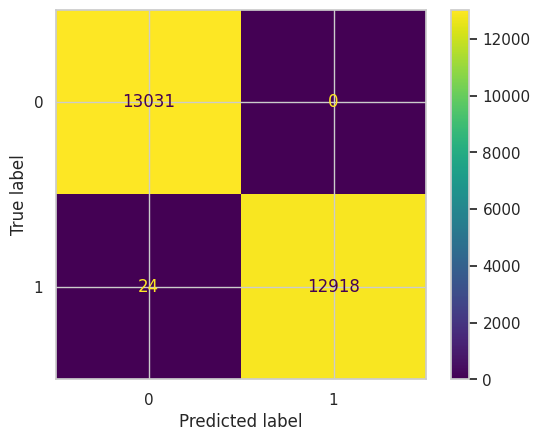

In [119]:
accuracy_rf = clf_rf.score(XTest, yTest)
print('Acuracia: \n' +str(accuracy_rf))

prediction_rf = clf_rf.predict(XTest)
cm_rf = confusion_matrix(prediction_rf, yTest)
cr_rf = classification_report(prediction_rf, yTest)
print('Metricas de Classificação: \n')
print(cr_rf)
print('Confusion Matrix: \n')
print(cm_rf)
ConfusionMatrixDisplay.from_predictions(prediction_rf, yTest)

### Gradient Boosting Classifier

In [120]:
clf_gb = GradientBoostingClassifier()

In [121]:
clf_gb = clf_gb.fit(XTrain, yTrain)

Acuracia: 
0.6471335617756901
Metricas de Classificação: 

              precision    recall  f1-score   support

           0       0.61      0.66      0.63     12036
           1       0.68      0.63      0.66     13937

    accuracy                           0.65     25973
   macro avg       0.65      0.65      0.65     25973
weighted avg       0.65      0.65      0.65     25973

Confusion Matrix: 

[[7963 4073]
 [5092 8845]]


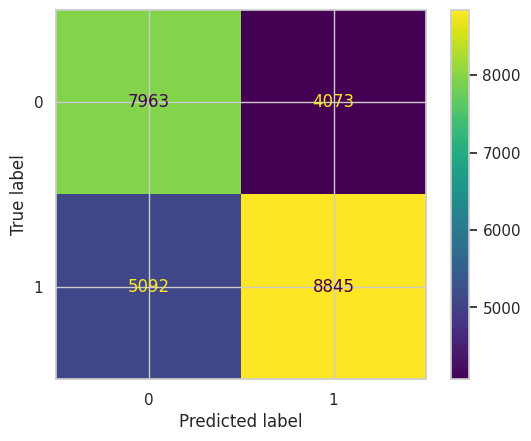

In [122]:
accuracy_gb = clf_gb.score(XTest, yTest)
print('Acuracia: \n' +str(accuracy_gb))

prediction_gb = clf_gb.predict(XTest)
cm_gb = confusion_matrix(prediction_gb, yTest)
cr_gb = classification_report(prediction_gb, yTest)
print('Metricas de Classificação: \n')
print(cr_gb)
print('Confusion Matrix: \n')
print(cm_gb)
ConfusionMatrixDisplay.from_predictions(prediction_gb, yTest)

### Xgboost


In [123]:
clf_xgb = XGBClassifier()

In [124]:
clf_xgb = clf_xgb.fit(XTrain, yTrain)

Acuracia: 
0.7893966811689062
Metricas de Classificação: 

              precision    recall  f1-score   support

           0       0.72      0.84      0.77     11199
           1       0.86      0.75      0.80     14774

    accuracy                           0.79     25973
   macro avg       0.79      0.80      0.79     25973
weighted avg       0.80      0.79      0.79     25973

Confusion Matrix: 

[[ 9392  1807]
 [ 3663 11111]]


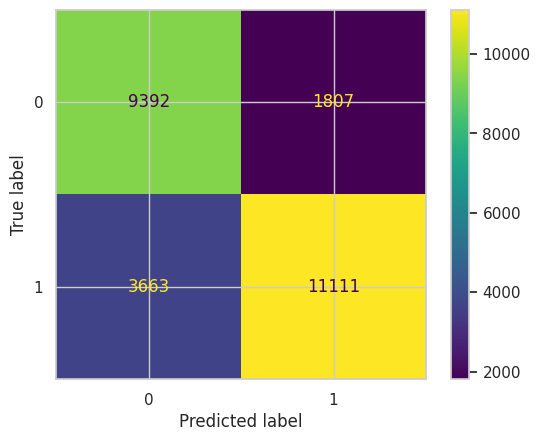

In [125]:
accuracy_xgb = clf_xgb.score(XTest, yTest)
print('Acuracia: \n' +str(accuracy_xgb))

prediction_xgb = clf_xgb.predict(XTest)
cm_xgb = confusion_matrix(prediction_xgb, yTest)
cr_xgb = classification_report(prediction_xgb, yTest)
print('Metricas de Classificação: \n')
print(cr_xgb)
print('Confusion Matrix: \n')
print(cm_xgb)
ConfusionMatrixDisplay.from_predictions(prediction_xgb, yTest)

### Light Gradient Boosting Model (LGBM)


In [126]:
clf_lgbm = LGBMClassifier()

In [127]:
clf_lgbm = clf_lgbm.fit(XTrain, yTrain)

[LightGBM] [Info] Number of positive: 30369, number of negative: 30232
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.124012 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1153
[LightGBM] [Info] Number of data points in the train set: 60601, number of used features: 214
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501130 -> initscore=0.004521
[LightGBM] [Info] Start training from score 0.004521


Acuracia: 
0.7434643668424903
Metricas de Classificação: 

              precision    recall  f1-score   support

           0       0.68      0.78      0.73     11422
           1       0.81      0.71      0.76     14551

    accuracy                           0.74     25973
   macro avg       0.74      0.75      0.74     25973
weighted avg       0.75      0.74      0.74     25973

Confusion Matrix: 

[[ 8907  2515]
 [ 4148 10403]]


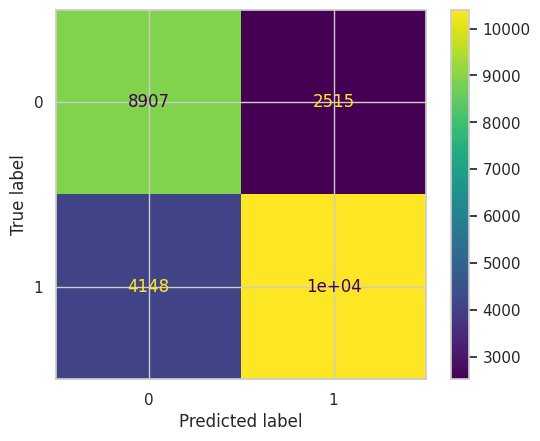

In [128]:
accuracy_lgbm = clf_lgbm.score(XTest, yTest)
print('Acuracia: \n' +str(accuracy_lgbm))

prediction_lgbm = clf_lgbm.predict(XTest)
cm_lgbm = confusion_matrix(prediction_lgbm, yTest)
cr_lgbm = classification_report(prediction_lgbm, yTest)
print('Metricas de Classificação: \n')
print(cr_lgbm)
print('Confusion Matrix: \n')
print(cm_lgbm)
ConfusionMatrixDisplay.from_predictions(prediction_lgbm, yTest)